In [24]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from datetime import date
from IPython.display import display
from random import randint, uniform
import warnings
import statistics

In [94]:
!pip3 install openpyxl


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\pc\AppData\Local\Programs\Python\Python311\python.exe -m pip install --upgrade pip


In [25]:
#Create Training Data
tickers = ['PLD','AMT','PSA','SPG','DLR','EQR']
training_array = {}

for ticker in tickers:
    training_array[ticker] = pd.read_excel('yahoo_finance_reits_data.xlsx',sheet_name=ticker,index_col=0).reset_index()[-2000:-500]
training_array

{'PLD':            Date        Open        High         Low       Close   Volume  \
 4487 2015-09-24   30.882412   31.019380   30.431220   30.624586  2524400   
 4488 2015-09-25   30.809901   31.333603   30.656816   31.148293  3885100   
 4489 2015-09-28   30.922710   31.059677   30.471518   30.632658  2770700   
 4490 2015-09-29   30.640709   31.293326   30.608483   31.212757  3059700   
 4491 2015-09-30   31.551149   31.583378   31.075787   31.341669  2860100   
 ...         ...         ...         ...         ...         ...      ...   
 5982 2021-09-01  128.617590  131.542456  128.217448  131.275681  3575500   
 5983 2021-09-02  131.237592  132.095037  130.408727  131.923553  2758800   
 5984 2021-09-03  131.513877  132.742898  130.151490  132.418976  2520000   
 5985 2021-09-07  131.675871  131.847354  129.522708  131.142334  2737500   
 5986 2021-09-08  130.732648  133.000133  130.399189  131.990234  2030700   
 
       Dividends  Stock Splits  
 4487        0.0             0  
 

In [26]:
#Create Test Data
test_array = {}

for ticker in tickers:
    test_array[ticker] = pd.read_excel('yahoo_finance_reits_data.xlsx',sheet_name=ticker,index_col=0).reset_index()[-500:]
test_array

{'PLD':            Date        Open        High         Low       Close   Volume  \
 5987 2021-09-09  131.094692  131.475776  128.322265  128.350845  2566600   
 5988 2021-09-10  128.741486  128.941549  127.207601  127.312401  1963500   
 5989 2021-09-13  128.398495  128.569978  126.340610  126.502571  1713800   
 5990 2021-09-14  126.950358  127.350500  125.492693  126.283455  1781400   
 5991 2021-09-15  126.721680  127.950701  125.816596  126.988441  2223700   
 ...         ...         ...         ...         ...         ...      ...   
 6482 2023-08-29  123.970001  125.349998  122.760002  125.099998  1833500   
 6483 2023-08-30  125.489998  125.959999  124.699997  125.699997  1849300   
 6484 2023-08-31  125.360001  125.910004  123.889999  124.199997  3277600   
 6485 2023-09-01  125.400002  125.570000  124.050003  124.589996  1591000   
 6486 2023-09-05  124.250000  124.500000  121.860001  122.050003  2854100   
 
       Dividends  Stock Splits  
 5987        0.0             0  
 

In [27]:
string = '(Open+Close+High+High)/3'
fields = ['Open','Close','High','Low','Volume']
def create_expression(string):
    for field in fields:
        string = string.replace(field,f'x[\'{field}\']')
    return string

print(create_expression(string))

(x['Open']+x['Close']+x['High']+x['High'])/3


In [28]:
def day_average(df):
    df['Day Ave'] = df.apply(lambda x: (x['Open']+x['Close']+x['High'])/3, axis=1)
    return df

In [29]:
def returns(df):
    df['Yesterday Ave'] = df['Day Ave'].shift()
    df['Dod Return'] = (df['Day Ave'] - df['Yesterday Ave'])/abs(df['Yesterday Ave'])
    df['Tommorrow Ave'] = df['Day Ave'].shift(-1)
    df['2nd Dod Return'] = (df['Tommorrow Ave'] - df['Day Ave'])/abs(df['Day Ave'])
    return df

In [30]:
def returns(df):
    df['Yesterday Ave'] = df['Day Ave'].shift()
    df['Dod Return'] = (df['Day Ave'] - df['Yesterday Ave'])/abs(df['Yesterday Ave'])
    df['Tommorrow Ave'] = df['Day Ave'].shift(-1)
    df['2nd Dod Return'] = (df['Tommorrow Ave'] - df['Day Ave'])/abs(df['Day Ave'])
    return df

In [31]:
def alpha_value(df,string):
    df['Alpha Value'] = df.apply(lambda x: eval(create_expression(string)), axis=1)
    return df

In [32]:
def calculate_alpha_performance(files_array,alpha_expr,transaction_cost):
    #print(f"Calculating performance for alpha: {alpha_expr}")
    combi = pd.DataFrame(files_array[next(iter(files_array))].reset_index()['Date']) # get list of dates from any ticker
    for key,value in files_array.items():
        day_average(value)
        returns(value)
        dod_return = pd.DataFrame(value[['Date','Dod Return']])
        dod_return.rename(columns={'Dod Return':f'{key} Dod Return'},inplace=True)
        combi = combi.merge(dod_return,on='Date',how='left')
    #print("\nDay on day returns for each ticker:")
    #print(files_array)
    #display(combi)
    
    combination = combi.melt(['Date'], var_name='Ticker', value_name='Dod Return') #need to double melt 2nd dod return
    combination.sort_values('Date', inplace=True)
    combination.dropna(inplace=True)
    #print("\nTranspose df:")
    #display(combination)
    
    combi2 = pd.DataFrame(files_array[next(iter(files_array))].reset_index()['Date'])
    for key,value in files_array.items():
        day_average(value)
        returns(value)
        dod_return = pd.DataFrame(value[['Date','2nd Dod Return']])
        dod_return.rename(columns={'2nd Dod Return':f'{key} Dod Return'},inplace=True)
        combi2 = combi2.merge(dod_return,on='Date',how='left')
    
    #print("\nDay on day returns for following day for each ticker:")
    #display(combi2)
    
    combination2 = combi2.melt(['Date'], var_name='Ticker', value_name='2nd Dod Return') #need to double melt 2nd dod return
    combination2.sort_values('Date', inplace=True)
    combination2.dropna(inplace=True)
    #print("\nTranspose df for following day:")
    #display(combination2)
    
    combi3 = pd.DataFrame(files_array[next(iter(files_array))].reset_index()['Date']) # get list of dates from any ticker
    for key,value in files_array.items():
        alpha_value(value,alpha_expr)
        alpha_return = pd.DataFrame(value[['Date','Alpha Value']])
        alpha_return.rename(columns={'Alpha Value':f'{key} Dod Return'},inplace=True)
        #print("TESTTTT")
        #display(alpha_return)
        #display(combi)
        combi3 = combi3.merge(alpha_return,on='Date',how='left')
    #print("COMBI 3")
    #display(combi3)
        
    #print("\nAlpha value for each ticker:")
    combination4 = combi3.melt(['Date'], var_name='Ticker', value_name='Alpha Value') #need to double melt 2nd dod return
    combination4.sort_values('Date', inplace=True)
    combination4.dropna(inplace=True)
    #print("COMBI 4")
    #display(combination4)
    
    
    combination3 = combination.merge(combination2,how='left',on=['Date','Ticker'])
    combination3 = combination3.merge(combination4,how='left',on=['Date','Ticker'])
    #print("\nMerge both dfs:")
    #display(combination3)
    
    combination3['Rank'] = combination3.sort_values(['Alpha Value'], ascending=[True]).groupby(['Date']).cumcount() + 1
    combination3['Alpha Rank'] = combination3['Rank'].apply(lambda x: x * (1/(len(tickers)-1)) - (1/(len(tickers)-1)))
    combination3['Centered 0'] = combination3['Alpha Rank'] - 0.5
    combination3['Abs Centered 0'] = abs(combination3['Centered 0'])
    combination3['Sum Rank'] = combination3.apply(lambda x: sum(combination3[combination3['Date']==x['Date']]['Abs Centered 0']),axis=1)
    combination3['Normalized'] = combination3.apply(lambda x: -x['Abs Centered 0']/x['Sum Rank'] if x['Centered 0'] < 0 else x['Abs Centered 0']/x['Sum Rank'], axis=1)
    combination3['Allocated'] = combination3['Normalized'] * 20
    combination3['PnL'] = combination3['Allocated'] * combination3['2nd Dod Return']
    #print("\nAllocate portfolio based on Alpha Rank:")
    #display(combination3)
    
    final = combination3[['Date','PnL']]
    final['PnL'] = final['PnL'] - (abs(final['PnL'])*transaction_cost)
    #final['PnL'] = final['PnL'].apply(lambda x: x - abs(x)*transaction_cost)
    pnl = final.groupby(['Date']).sum()
    pnl['PnL'] = pnl['PnL'].cumsum()
    pnl.reset_index(inplace=True)
    #display(pnl)
    #pnl.plot(kind='line',x='Date',y='PnL');
    
    return combination3,pnl
    

In [33]:
def objective(files_array,candidate_string):
    # Evaluate profit for alpha candidate for 1 year period
    resultDf,pnlDf = calculate_alpha_performance(files_array,candidate_string,0.01)
    one_year_return = pnlDf.iloc[-6,1] - pnlDf.iloc[-365,1]  
    six_month_return = pnlDf.iloc[-6,1] - pnlDf.iloc[-180,1]
    three_month_return = pnlDf.iloc[-6,1] - pnlDf.iloc[-90,1]  
    one_month_return = pnlDf.iloc[-6,1] - pnlDf.iloc[-30,1]  
    average_return = (one_month_return + three_month_return + six_month_return + one_year_return)/4
    print("AVERAGE RETURN: ", average_return)
    return average_return

In [34]:
p1 = '(Open + Volume + (Close) - Low / ((Low + Close)))'
p2 = 'Close - (High * High - Low + Open * High)'
r_cross = 0.8

def crossover(p1,p2,r_cross):
    operators = ['+','-','/','*']
    print("BEFORE CROSSOVER PAIR 1.",p1," 2.",p2)

    if uniform(0,1) < r_cross:
        #p1
        valid_crossover_p1 = []
        for idx in range(len(p1)):
            char = p1[idx]
            if char in operators:
                valid_crossover_p1.append(idx)
        #print(valid_crossover_p1)
        if len(valid_crossover_p1) < 1:
            print("AFTER CROSSOVER PAIR 1.",p1," 2.",p2,' NO CHANGE.')
            return [p1+' + '+p2,p2+' + '+p1]
        elif len(valid_crossover_p1) == 1:
            chosen_idx_p1 = valid_crossover_p1[0]
        else:
            chosen_idx_p1 = valid_crossover_p1[randint(0,len(valid_crossover_p1)-1)]         
        left_p1 = p1[:chosen_idx_p1-1]
        right_p1 = p1[chosen_idx_p1+2:]
        fixed_left_p1 = left_p1 + find_missing_bracket(left_p1)
        fixed_right_p1 = find_missing_bracket(right_p1) + right_p1
        #print("fixed left p1: ",fixed_left_p1," fixed right p1: ",fixed_right_p1)

        #p2
        valid_crossover_p2 = []
        for idx in range(len(p2)):
            char = p2[idx]
            if char in operators:
                valid_crossover_p2.append(idx)
        #print(valid_crossover_p2)
        if len(valid_crossover_p2) < 1:
            print("AFTER CROSSOVER PAIR 1.",p1," 2.",p2,' NO CHANGE.')
            return [p1+' + '+p2,p2+' + '+p1]
        elif len(valid_crossover_p2) == 1:
            chosen_idx_p2 = valid_crossover_p2[0]
        else:
            chosen_idx_p2 = valid_crossover_p2[randint(0,len(valid_crossover_p2)-1)]         
        left_p2 = p2[:chosen_idx_p2-1]
        right_p2 = p2[chosen_idx_p2+2:]
        fixed_left_p2 = left_p2 + find_missing_bracket(left_p2)
        fixed_right_p2 = find_missing_bracket(right_p2) + right_p2
        #print("fixed left p2: ",fixed_left_p2," fixed right p2: ",fixed_right_p2)
        
        c1 = fixed_left_p1 + ' + ' + fixed_right_p2
        c2 = fixed_left_p2 + ' + ' + fixed_right_p1
        print("OUTPUT PAIR: ",c1," 2.",c2, " CROSSED.")
        return [c1,c2]
    print("AFTER CROSSOVER PAIR 1.",p1," 2.",p2,' NO CHANGE.')
    return [p1,p2]

In [35]:
def genetic_algorithm(objective,files_array, n_iter, n_pop, r_cross, r_mut,fields):
    # initial population of random bitstring
    pop = generateAlphas(n_pop)
    
    # keep track of best solution
    best, best_eval = 0, objective(files_array,pop[0])
    # enumerate generations
    for gen in range(n_iter):
        print("--- Iteration ", str(gen+1), " out of ", str(n_iter), ". \nCurrent Population: ",pop)
        # evaluate all candidates in the population
        scores = [objective(files_array,c) for c in pop]
        print(scores)
        # check for new best solution
        for i in range(n_pop):
            if scores[i] > best_eval:
                best, best_eval = pop[i], scores[i]
                print(">%d, new best f(%s) = %.3f" % (gen, pop[i], scores[i]))
                
        # select parents
        selected = [selection(pop, scores) for _ in range(n_pop)]
        print("Selected Parents",selected)
        # create the next generation
        children = list()
        for i in range(0, n_pop, 2):
            # get selected parents in pairs
            p1, p2 = selected[i], selected[i+1]
        # crossover and mutation
            for c in crossover(p1, p2, r_cross):
                # mutation
                mutation(c, fields, r_mut)
                # store for next generation
                children.append(c)
        # replace population
        pop = children
    return [best, best_eval]

In [36]:
def selection(pop,scores,k=3):
    # first random selection
    selection_ix = randint(0,len(pop)-1)
    for ix in [randint(0,len(pop)-1) for x in range(k-1)]:
    # check if better (e.g. perform a tournament)
        if scores[ix] > scores[selection_ix]:
            selection_ix = ix
    return pop[selection_ix]

In [37]:
def mutation(string,fields,r_mut):
    print("BEFORE Mutation: ",string)
    for feature in fields:
        #print("STRING",string)
        #print(feature)
        split = string.split(feature)
        #print("split: ",split)
        terms = len(split)
        if terms > 1:
            replacements = []
            for i in range(terms-1):
                if uniform(0,1) < r_mut:
                    replacements.append(fields[randint(0,len(fields)-1)])
                else:
                    replacements.append(feature)
            #print("replacements: ",replacements)            
        string = ''
        for i in range(len(split)):
            string += split[i]
            if i < (len(split)-1):
                string += replacements[i]
    print("After Mutation: ",string)


In [38]:
from random import random, randint, choice

def randomAlpha(prob,datafields):
    p = random()
    if p > prob:
        return datafields[randint(0, 4)]
    elif randint(0, 1) == 0:
        return ParenthesizedExpression(randomAlpha(prob / 1.2,datafields))
    else:
        left = randomAlpha(prob / 1.2,datafields)
        op = choice(["+", "-", "*", "/"])
        right = randomAlpha(prob / 1.2,datafields)
        return BinaryExpression(left, op, right)
        #return str(left) + ' ' + str(op) + ' ' + str(right) 

def generateAlphas(number):
    past_alphas = []
    alphas_to_sim = []
    for i in range(number):
        duplicate = True
        while duplicate:
            generated = randomAlpha(1,fields)
            if generated not in past_alphas:
                duplicate = False
                #past_alphas.append(generated) # use this to output expressions
                past_alphas.append(str(generated)) # use this to output string
    return past_alphas


In [39]:
# Possible additions include methods to evaluate expressions and generate
# some random expressions.

class Expression:
    pass

class Number(Expression):
    def __init__(self, num):
        self.num = num

    def __str__(self):
        return str(self.num)

class BinaryExpression(Expression):
    def __init__(self, left, op, right):
        self.left = left
        self.op = op
        self.right = right

    def __str__(self):
        return str(self.left) + " " + self.op + " "  + str(self.right)

class ParenthesizedExpression(Expression):
    def __init__(self, exp):
        self.exp = exp

    def __str__(self):
        return "(" + str(self.exp) + ")"

e1 = Number(5)

In [40]:
def find_missing_bracket(input_string):
    # return the number of missing brackets
    close_bracket_count = 0
    open_bracket_count = 0
    for char in input_string:
        if char == '(':
            open_bracket_count += 1
        elif char == ')':
            close_bracket_count += 1
    abs_difference = abs(open_bracket_count-close_bracket_count) 
    if open_bracket_count > close_bracket_count:
        return abs_difference*")"
    elif close_bracket_count > open_bracket_count:
        return abs_difference*"("
    else:
        return ""

In [41]:
n_pop = 10
n_iter = 20
r_cross = 1 # crossover rate 0.8
r_mut = 0.2 # flip bits with probability

In [22]:
genetic_algorithm(objective, training_array, n_iter, n_pop, r_cross, r_mut, fields)

AVERAGE RETURN:  -1.755192846518538
--- Iteration  1  out of  20 . 
Current Population:  ['((((Open))))', '(((High + Open))) / (Volume / High * Open) * (Volume / Open)', '(Open)', '(((High + (Open)))) - Open', '(Volume * Low) * (Low) * Open - Open', '(High) + (Open * Open * High) + Volume - (Open) + (Close / Volume + Open) / (Volume / High + (((Low + (Volume)))) * ((Low)))', '((Volume * Open)) / Low / (Volume) + (((Open)))', 'Close / (Close + Low) * High + (Low) * High - (((High - (Open))) * Volume + Volume)', '(((Low)))', '(Low)']
AVERAGE RETURN:  -1.755192846518538
AVERAGE RETURN:  11.136936000451165
AVERAGE RETURN:  -1.755192846518538
AVERAGE RETURN:  -1.6377872718853157
AVERAGE RETURN:  -0.8092627159000944
AVERAGE RETURN:  0.43388389895373713
AVERAGE RETURN:  -1.755192846518538
AVERAGE RETURN:  -7.5628125815702045
AVERAGE RETURN:  -1.6632075521369372
AVERAGE RETURN:  -1.6632075521369372
[-1.755192846518538, 11.136936000451165, -1.755192846518538, -1.6377872718853157, -0.80926271590

AVERAGE RETURN:  0.20394096359576297
AVERAGE RETURN:  -1.755192846518538
AVERAGE RETURN:  1.5973032917927017
AVERAGE RETURN:  1.152696185160473
AVERAGE RETURN:  -1.7043201945358415
AVERAGE RETURN:  1.1657313960194111
AVERAGE RETURN:  1.627457932527858
AVERAGE RETURN:  1.6137878618266455
AVERAGE RETURN:  1.1303764282276738
AVERAGE RETURN:  1.627457932527858
[0.20394096359576297, -1.755192846518538, 1.5973032917927017, 1.152696185160473, -1.7043201945358415, 1.1657313960194111, 1.627457932527858, 1.6137878618266455, 1.1303764282276738, 1.627457932527858]
Selected Parents ['(((High + Open))) / (Volume) + (Volume) + (Open) * (Volume / Open)', '(((High))) + (Volume / Open)', '(((High))) + (Volume / Open)', '(((High))) + (Volume / Open)', '(((High))) + (Volume / Open)', '(((High + (Open)))) + (Open) + (((Open))) / (Volume) + (Volume / Open)', '(((High))) + (Volume / Open)', '(((High))) + (Volume / Open)', '(((High))) + (Volume / Open)', '(((High + Open))) + (Volume / Open)']
BEFORE CROSSOVER

AVERAGE RETURN:  -1.6953551947139023
AVERAGE RETURN:  1.193309775466186
AVERAGE RETURN:  0.09739255062631513
AVERAGE RETURN:  1.1303764282276738
AVERAGE RETURN:  -1.6953551947139023
AVERAGE RETURN:  1.2372943301143742
AVERAGE RETURN:  1.2372943301143742
AVERAGE RETURN:  1.2372943301143742
AVERAGE RETURN:  -1.6953551947139023
AVERAGE RETURN:  1.193309775466186
[-1.6953551947139023, 1.193309775466186, 0.09739255062631513, 1.1303764282276738, -1.6953551947139023, 1.2372943301143742, 1.2372943301143742, 1.2372943301143742, -1.6953551947139023, 1.193309775466186]
Selected Parents ['(((High))) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Volume) + (Volume / Open)', '(((High))) + (((Open))) / (Volume) + (Volume) + (Volume / Open)', '(((High))) + (((Open))) / (Volume) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (((Open))) + (Volume / Open)', '(((High))) + (Volume) + (((Open))) + (Volume / Open)', '(((High))) + (Volume) + (((Ope

AVERAGE RETURN:  -1.6953551947139023
AVERAGE RETURN:  1.2372943301143742
AVERAGE RETURN:  -1.6953551947139023
AVERAGE RETURN:  1.1753001117195612
AVERAGE RETURN:  1.627457932527858
AVERAGE RETURN:  1.2036531497415284
AVERAGE RETURN:  1.175300111719561
AVERAGE RETURN:  -1.7043201945358415
AVERAGE RETURN:  1.2372943301143742
AVERAGE RETURN:  -1.6953551947139023
[-1.6953551947139023, 1.2372943301143742, -1.6953551947139023, 1.1753001117195612, 1.627457932527858, 1.2036531497415284, 1.175300111719561, -1.7043201945358415, 1.2372943301143742, -1.6953551947139023]
Selected Parents ['(((High))) + (Volume / Open)', '(((High))) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Volume / Open)', '(((High))) + (((Open))) / (Volume) + (Volume) + (Volume) + (Volume) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Volume / Open)', '(((High))) + (Open)', '(((High))) + (Volume) + (Volume / Open)', '(((High))) + (Volume / Open)', '(((High))) + (

AVERAGE RETURN:  -1.6953551947139023
AVERAGE RETURN:  1.1986218140228533
AVERAGE RETURN:  1.2372943301143742
AVERAGE RETURN:  -1.6953551947139023
AVERAGE RETURN:  1.1303764282276738
AVERAGE RETURN:  1.1303764282276738
AVERAGE RETURN:  1.627457932527858
AVERAGE RETURN:  1.2372943301143742
AVERAGE RETURN:  1.627457932527858
AVERAGE RETURN:  1.2372943301143742
[-1.6953551947139023, 1.1986218140228533, 1.2372943301143742, -1.6953551947139023, 1.1303764282276738, 1.1303764282276738, 1.627457932527858, 1.2372943301143742, 1.627457932527858, 1.2372943301143742]
Selected Parents ['(((High))) + (Volume / Open)', '(((High))) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Open)', '(((High))) + (Volume / Open)', '(((High))) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Volume / Open)', '(((High))) + (Volume / Open)', '(((High))) + (Volume / Open)', '(((High))) + (Volume / Open)', '(((High))) + (Volume) + (Volume / Open)']
BEFORE CROSSOVER PAIR 1. (((High))) + (Volume / Open)  

AVERAGE RETURN:  1.1303764282276738
AVERAGE RETURN:  1.2372943301143742
AVERAGE RETURN:  1.1986218140228533
AVERAGE RETURN:  1.1303764282276738
AVERAGE RETURN:  1.1303764282276738
AVERAGE RETURN:  1.1303764282276738
AVERAGE RETURN:  1.193309775466186
AVERAGE RETURN:  -1.6953551947139023
AVERAGE RETURN:  1.1303764282276738
AVERAGE RETURN:  1.2372943301143742
[1.1303764282276738, 1.2372943301143742, 1.1986218140228533, 1.1303764282276738, 1.1303764282276738, 1.1303764282276738, 1.193309775466186, -1.6953551947139023, 1.1303764282276738, 1.2372943301143742]
Selected Parents ['(((High))) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Open)', '(((High))) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Volume) + (Volume) + (Volume / Open)', '(((High))) + (Volume

AVERAGE RETURN:  1.1303764282276738
AVERAGE RETURN:  1.2372943301143742
AVERAGE RETURN:  1.2036531497415284
AVERAGE RETURN:  1.627457932527858
AVERAGE RETURN:  1.2372943301143742
AVERAGE RETURN:  -1.6953551947139023
AVERAGE RETURN:  1.627457932527858
AVERAGE RETURN:  1.627457932527858
AVERAGE RETURN:  1.2372943301143742
AVERAGE RETURN:  1.627457932527858
[1.1303764282276738, 1.2372943301143742, 1.2036531497415284, 1.627457932527858, 1.2372943301143742, -1.6953551947139023, 1.627457932527858, 1.627457932527858, 1.2372943301143742, 1.627457932527858]
Selected Parents ['(((High))) + (Volume / Open)', '(((High))) + (Volume / Open)', '(((High))) + (Volume) + (Volume / Open)', '(((High))) + (Volume / Open)', '(((High))) + (Volume / Open)', '(((High))) + (Volume / Open)', '(((High))) + (Volume) + (Volume / Open)', '(((High))) + (Volume / Open)', '(((High))) + (Volume / Open)', '(((High))) + (Volume / Open)']
BEFORE CROSSOVER PAIR 1. (((High))) + (Volume / Open)  2. (((High))) + (Volume / Open

AVERAGE RETURN:  1.1303764282276738
AVERAGE RETURN:  1.193309775466186
AVERAGE RETURN:  1.1303764282276738
AVERAGE RETURN:  1.1303764282276738
AVERAGE RETURN:  -1.6953551947139023
AVERAGE RETURN:  1.1303764282276738
AVERAGE RETURN:  1.1303764282276738
AVERAGE RETURN:  1.193309775466186
AVERAGE RETURN:  1.1303764282276738
AVERAGE RETURN:  1.193309775466186
[1.1303764282276738, 1.193309775466186, 1.1303764282276738, 1.1303764282276738, -1.6953551947139023, 1.1303764282276738, 1.1303764282276738, 1.193309775466186, 1.1303764282276738, 1.193309775466186]
Selected Parents ['(((High))) + (Volume) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Volume) + (Open)', '(((High))) + (Volume) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Volume) + (Volume / Open)', '(((High))) + (Volume) + (Open)', '(((High))) + (Volume)

['(((High + Open))) / (Volume / High * Open) * (Volume / Open)',
 11.136936000451165]

In [42]:
def calculate_alpha_performance_test(files_array,alpha_expr,transaction_cost):
    print(f"Calculating performance for alpha: {alpha_expr}")
    combi = pd.DataFrame(files_array[next(iter(files_array))].reset_index()['Date']) # get list of dates from any ticker
    for key,value in files_array.items():
        day_average(value)
        returns(value)
        dod_return = pd.DataFrame(value[['Date','Dod Return']])
        dod_return.rename(columns={'Dod Return':f'{key} Dod Return'},inplace=True)
        combi = combi.merge(dod_return,on='Date',how='left')
    print("\nDay on day returns for each ticker:")
    print(files_array)
    display(combi)
    
    combination = combi.melt(['Date'], var_name='Ticker', value_name='Dod Return') #need to double melt 2nd dod return
    combination.sort_values('Date', inplace=True)
    combination.dropna(inplace=True)
    print("\nTranspose df:")
    display(combination)
    
    combi2 = pd.DataFrame(files_array[next(iter(files_array))].reset_index()['Date'])
    for key,value in files_array.items():
        day_average(value)
        returns(value)
        dod_return = pd.DataFrame(value[['Date','2nd Dod Return']])
        dod_return.rename(columns={'2nd Dod Return':f'{key} Dod Return'},inplace=True)
        combi2 = combi2.merge(dod_return,on='Date',how='left')
    
    print("\nDay on day returns for following day for each ticker:")
    display(combi2)
    
    combination2 = combi2.melt(['Date'], var_name='Ticker', value_name='2nd Dod Return') #need to double melt 2nd dod return
    combination2.sort_values('Date', inplace=True)
    combination2.dropna(inplace=True)
    print("\nTranspose df for following day:")
    display(combination2)
    
    combi3 = pd.DataFrame(files_array[next(iter(files_array))].reset_index()['Date']) # get list of dates from any ticker
    for key,value in files_array.items():
        alpha_value(value,alpha_expr)
        alpha_return = pd.DataFrame(value[['Date','Alpha Value']])
        alpha_return.rename(columns={'Alpha Value':f'{key} Dod Return'},inplace=True)
        #print("TESTTTT")
        #display(alpha_return)
        #display(combi)
        combi3 = combi3.merge(alpha_return,on='Date',how='left')
    print("COMBI 3")
    display(combi3)
        
    print("\nAlpha value for each ticker:")
    combination4 = combi3.melt(['Date'], var_name='Ticker', value_name='Alpha Value') #need to double melt 2nd dod return
    combination4.sort_values('Date', inplace=True)
    combination4.dropna(inplace=True)
    print("COMBI 4")
    display(combination4)
    
    
    combination3 = combination.merge(combination2,how='left',on=['Date','Ticker'])
    combination3 = combination3.merge(combination4,how='left',on=['Date','Ticker'])
    print("\nMerge both dfs:")
    display(combination3)
    
    combination3['Rank'] = combination3.sort_values(['Alpha Value'], ascending=[True]).groupby(['Date']).cumcount() + 1
    combination3['Alpha Rank'] = combination3['Rank'].apply(lambda x: x * (1/(len(tickers)-1)) - (1/(len(tickers)-1)))
    combination3['Centered 0'] = combination3['Alpha Rank'] - 0.5
    combination3['Abs Centered 0'] = abs(combination3['Centered 0'])
    combination3['Sum Rank'] = combination3.apply(lambda x: sum(combination3[combination3['Date']==x['Date']]['Abs Centered 0']),axis=1)
    combination3['Normalized'] = combination3.apply(lambda x: -x['Abs Centered 0']/x['Sum Rank'] if x['Centered 0'] < 0 else x['Abs Centered 0']/x['Sum Rank'], axis=1)
    combination3['Allocated'] = combination3['Normalized'] * 20
    combination3['PnL'] = combination3['Allocated'] * combination3['2nd Dod Return']
    print("\nAllocate portfolio based on Alpha Rank:")
    display(combination3)
    
    final = combination3[['Date','PnL']]
    final['PnL'] = final['PnL'] - (abs(final['PnL'])*transaction_cost)
    pnl = final.groupby(['Date']).sum()
    pnl['PnL'] = pnl['PnL'].cumsum()
    pnl.reset_index(inplace=True)
    display(pnl)
    pnl.plot(kind='line',x='Date',y='PnL');
    
    return combination3,pnl
    

Calculating performance for alpha: (((High + Open))) / (Volume / High * Open) * (Volume / Open)

Day on day returns for each ticker:
{'PLD':            Date        Open        High         Low       Close   Volume  \
5987 2021-09-09  131.094692  131.475776  128.322265  128.350845  2566600   
5988 2021-09-10  128.741486  128.941549  127.207601  127.312401  1963500   
5989 2021-09-13  128.398495  128.569978  126.340610  126.502571  1713800   
5990 2021-09-14  126.950358  127.350500  125.492693  126.283455  1781400   
5991 2021-09-15  126.721680  127.950701  125.816596  126.988441  2223700   
...         ...         ...         ...         ...         ...      ...   
6482 2023-08-29  123.970001  125.349998  122.760002  125.099998  1833500   
6483 2023-08-30  125.489998  125.959999  124.699997  125.699997  1849300   
6484 2023-08-31  125.360001  125.910004  123.889999  124.199997  3277600   
6485 2023-09-01  125.400002  125.570000  124.050003  124.589996  1591000   
6486 2023-09-05  124.25

,Date,PLD Dod Return,AMT Dod Return,PSA Dod Return,SPG Dod Return,DLR Dod Return,EQR Dod Return
0,2021-09-09,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-09-10,-0.015159,-0.017175,-0.011471,-0.007750,-0.010367,-0.011094
2,2021-09-13,-0.003960,0.002276,-0.001970,0.005583,-0.010455,-0.000041
3,2021-09-14,-0.007528,-0.000067,-0.008942,0.000866,-0.002681,-0.001134
4,2021-09-15,0.002829,0.002507,0.002140,-0.001018,0.008859,-0.000892
...,...,...,...,...,...,...,...
495,2023-08-29,0.005019,0.012066,0.001704,0.009716,0.016932,0.001902
496,2023-08-30,0.007291,0.013178,0.008146,0.007615,0.014150,0.009648
497,2023-08-31,-0.004454,-0.001913,-0.004206,-0.001787,0.005540,-0.005134
498,2023-09-01,0.000240,-0.003924,-0.006587,0.010887,0.006243,-0.007715



Transpose df:


,Date,Ticker,Dod Return
1501,2021-09-10,SPG Dod Return,-0.007750
1001,2021-09-10,PSA Dod Return,-0.011471
1,2021-09-10,PLD Dod Return,-0.015159
2001,2021-09-10,DLR Dod Return,-0.010367
501,2021-09-10,AMT Dod Return,-0.017175
...,...,...,...
1999,2023-09-05,SPG Dod Return,0.002409
999,2023-09-05,AMT Dod Return,-0.004306
499,2023-09-05,PLD Dod Return,-0.012674
2499,2023-09-05,DLR Dod Return,-0.008515



Day on day returns for following day for each ticker:


,Date,PLD Dod Return,AMT Dod Return,PSA Dod Return,SPG Dod Return,DLR Dod Return,EQR Dod Return
0,2021-09-09,-0.015159,-0.017175,-0.011471,-0.007750,-0.010367,-0.011094
1,2021-09-10,-0.003960,0.002276,-0.001970,0.005583,-0.010455,-0.000041
2,2021-09-13,-0.007528,-0.000067,-0.008942,0.000866,-0.002681,-0.001134
3,2021-09-14,0.002829,0.002507,0.002140,-0.001018,0.008859,-0.000892
4,2021-09-15,0.000636,0.000247,-0.001760,0.014544,0.004840,-0.000933
...,...,...,...,...,...,...,...
495,2023-08-29,0.007291,0.013178,0.008146,0.007615,0.014150,0.009648
496,2023-08-30,-0.004454,-0.001913,-0.004206,-0.001787,0.005540,-0.005134
497,2023-08-31,0.000240,-0.003924,-0.006587,0.010887,0.006243,-0.007715
498,2023-09-01,-0.012674,-0.004306,-0.012456,0.002409,-0.008515,-0.003965



Transpose df for following day:


,Date,Ticker,2nd Dod Return
0,2021-09-09,PLD Dod Return,-0.015159
1000,2021-09-09,PSA Dod Return,-0.011471
2000,2021-09-09,DLR Dod Return,-0.010367
500,2021-09-09,AMT Dod Return,-0.017175
2500,2021-09-09,EQR Dod Return,-0.011094
...,...,...,...
1498,2023-09-01,PSA Dod Return,-0.012456
2998,2023-09-01,EQR Dod Return,-0.003965
498,2023-09-01,PLD Dod Return,-0.012674
1998,2023-09-01,SPG Dod Return,0.002409


COMBI 3


,Date,PLD Dod Return,AMT Dod Return,PSA Dod Return,SPG Dod Return,DLR Dod Return,EQR Dod Return
0,2021-09-09,2.008729,2.012016,2.000000,2.032006,2.024763,2.005391
1,2021-09-10,2.004664,2.006683,2.023829,2.000914,2.015389,2.000000
2,2021-09-13,2.004008,2.019366,2.021680,2.051186,2.014441,2.039346
3,2021-09-14,2.009466,2.025470,2.000000,2.012341,2.017190,2.012418
4,2021-09-15,2.029190,2.012254,2.035568,2.058062,2.051081,2.027208
...,...,...,...,...,...,...,...
495,2023-08-29,2.033519,2.050142,2.030810,2.051600,2.077316,2.030793
496,2023-08-30,2.011250,2.027867,2.019803,2.020389,2.049484,2.024396
497,2023-08-31,2.013181,2.007216,2.000000,2.011653,2.013005,2.005050
498,2023-09-01,2.004069,2.000000,2.007993,2.022353,2.017452,2.004152



Alpha value for each ticker:
COMBI 4


,Date,Ticker,Alpha Value
0,2021-09-09,PLD Dod Return,2.008729
1000,2021-09-09,PSA Dod Return,2.000000
2000,2021-09-09,DLR Dod Return,2.024763
500,2021-09-09,AMT Dod Return,2.012016
2500,2021-09-09,EQR Dod Return,2.005391
...,...,...,...
1999,2023-09-05,SPG Dod Return,2.020167
999,2023-09-05,AMT Dod Return,2.031345
499,2023-09-05,PLD Dod Return,2.006040
2499,2023-09-05,DLR Dod Return,2.001592



Merge both dfs:


,Date,Ticker,Dod Return,2nd Dod Return,Alpha Value
0,2021-09-10,SPG Dod Return,-0.007750,0.005583,2.000914
1,2021-09-10,PSA Dod Return,-0.011471,-0.001970,2.023829
2,2021-09-10,PLD Dod Return,-0.015159,-0.003960,2.004664
3,2021-09-10,DLR Dod Return,-0.010367,-0.010455,2.015389
4,2021-09-10,AMT Dod Return,-0.017175,0.002276,2.006683
...,...,...,...,...,...
2989,2023-09-05,SPG Dod Return,0.002409,NaN,2.020167
2990,2023-09-05,AMT Dod Return,-0.004306,NaN,2.031345
2991,2023-09-05,PLD Dod Return,-0.012674,NaN,2.006040
2992,2023-09-05,DLR Dod Return,-0.008515,NaN,2.001592



Allocate portfolio based on Alpha Rank:


,Date,Ticker,Dod Return,2nd Dod Return,Alpha Value,Rank,Alpha Rank,Centered 0,Abs Centered 0,Sum Rank,Normalized,Allocated,PnL
0,2021-09-10,SPG Dod Return,-0.007750,0.005583,2.000914,2,0.2,-0.3,0.3,1.8,-0.166667,-3.333333,-0.018610
1,2021-09-10,PSA Dod Return,-0.011471,-0.001970,2.023829,6,1.0,0.5,0.5,1.8,0.277778,5.555556,-0.010945
2,2021-09-10,PLD Dod Return,-0.015159,-0.003960,2.004664,3,0.4,-0.1,0.1,1.8,-0.055556,-1.111111,0.004399
3,2021-09-10,DLR Dod Return,-0.010367,-0.010455,2.015389,5,0.8,0.3,0.3,1.8,0.166667,3.333333,-0.034848
4,2021-09-10,AMT Dod Return,-0.017175,0.002276,2.006683,4,0.6,0.1,0.1,1.8,0.055556,1.111111,0.002529
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2989,2023-09-05,SPG Dod Return,0.002409,NaN,2.020167,5,0.8,0.3,0.3,1.8,0.166667,3.333333,NaN
2990,2023-09-05,AMT Dod Return,-0.004306,NaN,2.031345,6,1.0,0.5,0.5,1.8,0.277778,5.555556,NaN
2991,2023-09-05,PLD Dod Return,-0.012674,NaN,2.006040,2,0.2,-0.3,0.3,1.8,-0.166667,-3.333333,NaN
2992,2023-09-05,DLR Dod Return,-0.008515,NaN,2.001592,1,0.0,-0.5,0.5,1.8,-0.277778,-5.555556,NaN


,Date,PnL
0,2021-09-10,-0.057966
1,2021-09-13,-0.016731
2,2021-09-14,0.004882
3,2021-09-15,0.099853
4,2021-09-16,0.063841
...,...,...
494,2023-08-29,27.845551
495,2023-08-30,27.904169
496,2023-08-31,28.004070
497,2023-09-01,28.044544


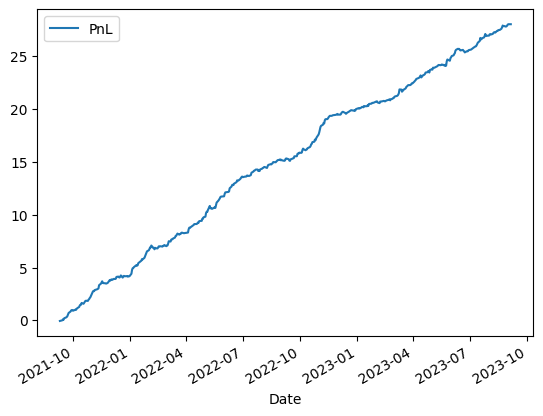

In [43]:
combi,pnl = calculate_alpha_performance_test(test_array,'(((High + Open))) / (Volume / High * Open) * (Volume / Open)',0.01)

In [44]:
float(pnl.iloc[-1,1])

28.044544450632703

In [45]:
combi

,Date,Ticker,Dod Return,2nd Dod Return,Alpha Value,Rank,Alpha Rank,Centered 0,Abs Centered 0,Sum Rank,Normalized,Allocated,PnL
0,2021-09-10,SPG Dod Return,-0.007750,0.005583,2.000914,2,0.2,-0.3,0.3,1.8,-0.166667,-3.333333,-0.018610
1,2021-09-10,PSA Dod Return,-0.011471,-0.001970,2.023829,6,1.0,0.5,0.5,1.8,0.277778,5.555556,-0.010945
2,2021-09-10,PLD Dod Return,-0.015159,-0.003960,2.004664,3,0.4,-0.1,0.1,1.8,-0.055556,-1.111111,0.004399
3,2021-09-10,DLR Dod Return,-0.010367,-0.010455,2.015389,5,0.8,0.3,0.3,1.8,0.166667,3.333333,-0.034848
4,2021-09-10,AMT Dod Return,-0.017175,0.002276,2.006683,4,0.6,0.1,0.1,1.8,0.055556,1.111111,0.002529
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2989,2023-09-05,SPG Dod Return,0.002409,NaN,2.020167,5,0.8,0.3,0.3,1.8,0.166667,3.333333,NaN
2990,2023-09-05,AMT Dod Return,-0.004306,NaN,2.031345,6,1.0,0.5,0.5,1.8,0.277778,5.555556,NaN
2991,2023-09-05,PLD Dod Return,-0.012674,NaN,2.006040,2,0.2,-0.3,0.3,1.8,-0.166667,-3.333333,NaN
2992,2023-09-05,DLR Dod Return,-0.008515,NaN,2.001592,1,0.0,-0.5,0.5,1.8,-0.277778,-5.555556,NaN


In [46]:
pnl.iloc[-1,0]

Timestamp('2023-09-05 00:00:00')

In [47]:
total_trade_amount = 20
portfolio_value = total_trade_amount+float(pnl.iloc[-1,1])
expected_return_total = (portfolio_value-total_trade_amount)/total_trade_amount+1
print('expected return: ',expected_return_total)

#annualise rate of return
delta = pnl.iloc[-1,0] - pnl.iloc[0,0]
years_delta = delta.days/365
print('number of years:',years_delta)

annualised_return = pow(expected_return_total,1/years_delta) - 1
print('annualised return: ',annualised_return)

expected return:  2.402227222531635
number of years: 1.9863013698630136
annualised return:  0.5546030107241113


In [48]:
import numpy as np

In [49]:
stddev = np.std(combi['PnL'].dropna().to_list())
print('standard dev: ',stddev)

standard dev:  0.05450611099802983


In [50]:
# US 10 Year Treasury Yield: risk free rate:
risk_free_rate_2019_to_2024 = [0.02,0.01,0.015,0.03,0.035,0.04]
average_rfr = sum(risk_free_rate_2019_to_2024)/len(risk_free_rate_2019_to_2024)
print('average risk free rate: ',average_rfr)

average risk free rate:  0.024999999999999998


In [51]:
sharpe_ratio = (annualised_return-average_rfr)/stddev
print('Sharpe ratio: ',sharpe_ratio)

Sharpe ratio:  9.716396951219915


In [92]:
generateAlphas(10)

['((Low / ((Volume)) * Volume)) / (((Low)) / Low / (Open))',
 '(Open / Volume * Volume)',
 'Volume + High + Low - ((Volume))',
 'High * ((Open))',
 'Volume - Low',
 '((Volume))',
 '(Open + (Open))',
 '(Close) * Close + Low * Low - Volume * Close',
 '(Low)',
 '(Open + (High) / Low)']

In [22]:
class Node:
    def __init__(self, value):
        self.value = value
        self.children = []

def parse_expression(tokens):
    node = parse_term(tokens)

    while tokens and tokens[0] in ['+', '-']:
        operator = tokens.pop(0)
        right = parse_term(tokens)
        new_node = Node(operator)
        new_node.children.extend([node, right])
        node = new_node

    return node

def parse_term(tokens):
    node = parse_factor(tokens)

    while tokens and tokens[0] in ['*', '/']:
        operator = tokens.pop(0)
        right = parse_factor(tokens)
        new_node = Node(operator)
        new_node.children.extend([node, right])
        node = new_node

    return node

def parse_factor(tokens):
    if not tokens:
        raise ValueError("Unexpected end of expression")

    token = tokens.pop(0)

    if token.isalnum():  # Changed from isdigit() to isalnum() to handle alphabetic tokens
        return Node(token)
    elif token == '(':
        node = parse_expression(tokens)
        if tokens[0] != ')':
            raise ValueError("Expected ')'")
        tokens.pop(0)  # Consume ')'
        return node
    else:
        raise ValueError(f"Unexpected token: {token}")

def parse_math_expression(expression):
    tokens = expression.replace('(', ' ( ').replace(')', ' ) ').split()
    return parse_expression(tokens)

# Example usage
math_expression = "((Open / Volume) + Open - Open * (Volume) / Volume * ((Close - Open)))"
parse_tree_root = parse_math_expression(math_expression)

math_expression = "((Open / Volume) + Open - Open * (Volume) / Volume * ((Close - Open)))"
p1 = parse_math_expression(math_expression)

math_expression = "(Open - Open * (Volume) / Volume * ((Close - Open)))"
p2 = parse_math_expression(math_expression)

# Helper function to visualize the tree
def print_tree(node, depth=0, prefix=""):
    # Handle the root node
    if depth == 0:
        print(node.value)
    else:
        print(prefix + "└── " + node.value)

    if node.children:
        new_prefix = prefix + ("    " if depth == 0 else "│   ")
        for i, child in enumerate(node.children):
            # Update the prefix for the last child
            if i == len(node.children) - 1:
                new_prefix = prefix + "    "
            print_tree(child, depth + 1, new_prefix)

print_tree(parse_tree_root)

-
    └── +
    │   └── /
    │   │   └── Open
    │       └── Volume
        └── Open
    └── *
    │   └── /
    │   │   └── *
    │   │   │   └── Open
    │   │       └── Volume
    │       └── Volume
        └── -
        │   └── Close
            └── Open


In [23]:
def tree_to_expression(node):
    # If the node is a leaf (has no children), return its value
    if not node.children:
        return node.value

    # If the node is not a leaf, it should be an operator
    # We then recursively get the expressions of its children
    left_expr = tree_to_expression(node.children[0])
    right_expr = tree_to_expression(node.children[1])

    # Construct and return the expression string
    return f"({left_expr} {node.value} {right_expr})"

# Example usage
# Assuming root is the root of your expression tree
expression = tree_to_expression(p1)
print(expression)

(((Open / Volume) + Open) - (((Open * Volume) / Volume) * (Close - Open)))


In [50]:
objective(files_array,'((Low)) + Open / (Open) - Open')

Calculating performance for alpha: ((Low)) + Open / (Open) - Open
AVERAGE RETURN:  8.880583934374993


8.880583934374993

In [97]:
print(crossover(p1,p2,r_cross))

fixed left p1:  (Open + Volume)  fixed right p1:  ((Close) - Low / ((Low + Close)))
fixed left p2:  Close - (High * High - Low + Open)  fixed right p2:  (High)
['(Open + Volume) + (High)', 'Close - (High * High - Low + Open) + ((Close) - Low / ((Low + Close)))']


In [41]:
crossover(p1,p2,r_cross)

fixed left p1:  (Open + Volume + (Close) - Low / ((Low)))  fixed right p1:  (((Close)))
fixed left p2:  Close - (High * High - Low)  fixed right p2:  (Open * High)


In [37]:
find_missing_bracket('(Open + Volume + (Close)')

')'